# ТЗ:
Необходимо создать систему алёртов для приложения.
Система должна с периодичность каждые 15 минут проверять ключевые метрики: 
- активные пользователи в ленте / мессенджере;
- просмотры;
- лайки;
- CTR;
- количество отправленных сообщений. 

В случае обнаружения аномального значения, в чат должен отправиться алерт - сообщение со следующей информацией: 
    ```метрика, ее значение, величина отклонения```.
    
В сообщение лучше добавить дополнительную информацию, которая поможет при исследовании причин возникновения аномалии.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import telegram
import pandahouse
from datetime import date, timedelta
import io
import sys
import os
import loggins_and_passwords as connect
from IPython.display import display

Разработаем прототип системы, а затем напишем скрипт, который будем автоматически запускать раз в 15 минут с помощью GitLab CI/CD.

***Сначала разработаем общую концепцию и проверим ее.***

In [2]:
connection = {
    'host': connect.host,         #os.environ.get("db_host"),
    'password': connect.password, #os.environ.get("db_password"),
    'user': connect.user          #os.environ.get("db_login")
}

def db_to_dataframe(query, connection):
    """
    db_to_dataframe(query, connection=connection)
    возвращает объект DataFrame выгруженный из базы.
    Параметры подключения к базе определены в переменной connection
    """
    return pandahouse.read_clickhouse(query, connection=connection)

Выгрузим данные по количеству пользователей ленты новостей, в разрезе 5 минут.

In [3]:

query = '''
SELECT 
    toStartOfInterval(toDateTime(time), INTERVAL 15 minute) AS time,
    count(DISTINCT user_id) AS cnt_users
FROM 
    {db}.feed_actions
WHERE     
    time >=  today() - INTERVAL 1 month and time < toStartOfInterval(now(), INTERVAL 15 minute)
GROUP BY 
    time
ORDER BY 
    time DESC
'''

df = db_to_dataframe(query, connection)

Найдем последний известный таймстемп, а так же таймстепы соотвественной пятиминутки в каждом дней месяца назад

In [4]:
current_time = df.time.max()

# для теста
#current_time = df[df.time == '2022-05-04 23:55:00'].time.max()

In [5]:
first_day_of_current_month = current_time.replace(day=1)
last_day_of_previous_month = first_day_of_current_month - timedelta(days=1)
start_of_period = last_day_of_previous_month.replace(day = current_time.day)

delta = timedelta(days=1)

dates = []
while start_of_period <= current_time:
    dates.append(start_of_period)
    start_of_period += delta                            

Возьмем значения соответствующие этим таймстемпам

In [6]:
data = df[df.time.isin(dates)]

Определим границы, в пределах которых значение метрики не будет считаться выбросом

In [7]:
def alert_intervals(df, column):
    
    first_quantile = df[column].quantile(0.25)
    third_quantile = df[column].quantile(0.75)
    iqr = third_quantile - first_quantile
    
    interval_low = first_quantile - 1.96* iqr
    interval_high = third_quantile + 1.96* iqr
        
    return(interval_low, interval_high)

column = 'cnt_users'
low, high = alert_intervals(data, column)



Сравним текущее значение с границами нормальности

In [8]:
current_value = data['cnt_users'].head(1).iloc[0]

if current_value < low or current_value > high:
    alert = True
else:
    alert = False
alert

False

Вот уже и вырисовалась простенькая моделька детекции. Соберем все в функцию, чтобы передавать только метрики и данные, а в ответ получать сигнал.

In [9]:
def is_alert(query, connection, metric, chart=False, dashbord=False):
    
    df = db_to_dataframe(query, connection)
    
    current_time = df.time.max()
    first_day_of_current_month = current_time.replace(day=1)
    last_day_of_previous_month = first_day_of_current_month - timedelta(days=1)
    start_of_period = last_day_of_previous_month.replace(day = current_time.day)

    delta = timedelta(days=1)

    dates = []
    while start_of_period <= current_time:
        dates.append(start_of_period)
        start_of_period += delta   
        
    data = df[df.time.isin(dates)]
    
    low, high = alert_intervals(data, metric)
    
    current_value = data[metric].head(1).iloc[0]

    if current_value < low or current_value > high:
        alert = True
    else:
        alert = False
    
    
    mean_val = data[metric].mean()
    
    
    
    if alert:
    
        if current_value<low: 
            direction = 'вниз'
        else: 
            direction = 'вверх'
        
        msg = f'''
        Метрика {metric}. 
        Текущее значение {current_value}. 
        Отклонение от среднего более {round(abs((current_value-mean_val)/mean_val)*100,2)}% {direction}.
        '''
        
        if chart:
            msg = msg+f'''Ссылка на риалтайм чарт в BI: {chart}'''
        
        if dashbord:
            msg = msg+f'''\n\tСсылка на риалтайм дашборд в BI: {dashbord}'''
        
        print(msg)
        
        sns.lineplot(data=data.iloc[:,:280], x='time', y=metric)
        plt.xticks([])
        plt.title(f'{metric} за последние сутки')
        plt.show()
        
    else:
        print(current_time, metric, 
              'low bound: ',round(float(low),2), 
              'upper bound: ',round(float(high),2), 
              'mean value: ',round(float(mean_val),2), 
              'current value: ',round(float(current_value),2))

Ну и протестируем. Мы знаем, что был выброс вверх по количеству пользователей ленты новостей после '2022-05-04 23:40:00' до '2022-05-05 00:10:00'
вот на этом промежутке и проверим, как мы детектируес выбросы


        Метрика feed_active_users в пятиминутном разрезе. 
        Текущее значение 774. 
        Отклонение от среднего более 303.12% вверх.
        Ссылка на риалтайм чарт в BI: http://superset.lab.karpov.courses/r/982
	Ссылка на риалтайм дашборд в BI: https://superset.lab.karpov.courses/superset/dashboard/734/


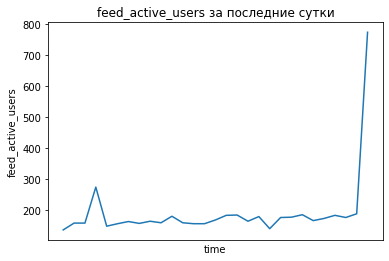

In [10]:
query = '''
SELECT 
    toStartOfInterval(toDateTime(time), INTERVAL 15 minute) AS time,
    count(DISTINCT user_id) AS feed_active_users
FROM 
    {db}.feed_actions
WHERE     
    time >=  today() - INTERVAL 1 month and time < '2022-05-05 00:05:00'--toStartOfInterval(now(), INTERVAL 15 minute)
GROUP BY 
    time
ORDER BY 
    time DESC
'''

chart = 'http://superset.lab/r/982'
dashbord = 'https://superset.lab/superset/dashboard/734/'

is_alert(query, connection, 'feed_active_users', chart, dashbord)





Логично, что если есть скачек пользователей, то должен быть скачек просмотров, а если не нарушился ctr, то должен быть и скачек лайков. Если скачка лайков не было, то должна быть аномалия по CTR. Проверим это


        Метрика feed_likes в пятиминутном разрезе. 
        Текущее значение 1064. 
        Отклонение от среднего более 136.93% вверх.
        Ссылка на риалтайм чарт в BI: http://superset.lab.karpov.courses/r/986
	Ссылка на риалтайм дашборд в BI: https://superset.lab.karpov.courses/superset/dashboard/734/


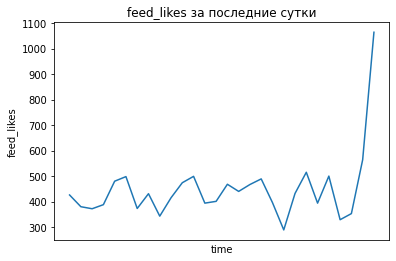


        Метрика feed_views в пятиминутном разрезе. 
        Текущее значение 5524. 
        Отклонение от среднего более 152.48% вверх.
        Ссылка на риалтайм чарт в BI: http://superset.lab.karpov.courses/r/985
	Ссылка на риалтайм дашборд в BI: https://superset.lab.karpov.courses/superset/dashboard/734/


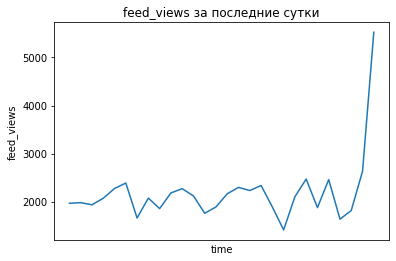

2022-05-04 23:55:00 feed_ctr low bound:  0.16 upper bound:  0.25 mean value:  0.21 current value:  0.19


In [11]:
query = '''
SELECT time time,
               SUMIf(cnt_actions, action ='like') feed_likes,
               SUMIf(cnt_actions, action ='view') feed_views,
               feed_likes/feed_views feed_ctr
   FROM
     (SELECT 
        toStartOfInterval(time, INTERVAL 15 minute) time,
        action,
        count(action) cnt_actions
      FROM {db}.feed_actions
      WHERE 
            time >=  today() - INTERVAL 1 month 
            and time < '2022-05-05 00:00:00'--toStartOfInterval(now(), INTERVAL 15 minute)
      group by time,
               action
      ORDER BY time desc)
   GROUP BY time
   ORDER BY time desc
'''

chart = 'http://superset.lab/r/986'
dashbord = 'https://superset.lab/superset/dashboard/734/'

is_alert(query, connection, 'feed_likes',chart,dashbord)

chart = 'http://superset.lab/r/985'
is_alert(query, connection, 'feed_views', chart, dashbord )

chart = 'http://superset.lab/r/987'
is_alert(query, connection, 'feed_ctr',chart, dashbord)

также мы знаем, что за последний месяц в количестве пользователей мессенджера не было никаких выбросов

In [13]:
query = '''
SELECT 
    toStartOfInterval(toDateTime(time), INTERVAL 15 minute) AS time,
    count(DISTINCT user_id) AS message_active_users,
    count(user_id) as send_messages
FROM 
    {db}.message_actions
WHERE     
    time >=  today() - INTERVAL 1 month and time < toStartOfInterval(now(), INTERVAL 15 minute)
GROUP BY 
    time
ORDER BY 
    time DESC
'''

chart = 'http://superset.lab/r/992'
dashbord = 'http://superset.lab/r/991'

is_alert(query, connection, 'message_active_users', chart, dashbord)


chart = 'http://superset.lab/r/990'
is_alert(query, connection, 'send_messages', chart, dashbord)



2022-05-07 16:45:00 message_active_users low bound:  88.02 upper bound:  151.98 mean value:  121.26 current value:  114.0
2022-05-07 16:45:00 send_messages low bound:  146.06 upper bound:  214.94 mean value:  180.52 current value:  158.0


Тогда вся наша система будет выглядеть

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import telegram
import pandahouse
from datetime import date, timedelta
import io
import sys
import os



def db_to_dataframe(query):
    """
    db_to_dataframe(query, connection=connection)
    возвращает объект DataFrame выгруженный из базы.
    Параметры подключения к базе определены в переменной connection
    """
    
    connection = {
    'host': os.environ.get("db_host"),
    'password': os.environ.get("db_password"),
    'user': os.environ.get("db_login")
    }
    
    return pandahouse.read_clickhouse(query, connection=connection)

def alert_intervals(df, column):
    
    first_quantile = df[column].quantile(0.25)
    third_quantile = df[column].quantile(0.75)
    iqr = third_quantile - first_quantile
    
    interval_low = first_quantile - 1.96* iqr
    interval_high = third_quantile + 1.96* iqr
        
    return(interval_low, interval_high)


def is_alert(query, metric, chart=False, dashbord=False):
    
    df = db_to_dataframe(query)
    
    current_time = df.time.max()
    first_day_of_current_month = current_time.replace(day=1)
    last_day_of_previous_month = first_day_of_current_month - timedelta(days=1)
    start_of_period = last_day_of_previous_month.replace(day = current_time.day)

    delta = timedelta(days=1)

    dates = []
    while start_of_period <= current_time:
        dates.append(start_of_period)
        start_of_period += delta   
        
    data = df[df.time.isin(dates)]
    
    low, high = alert_intervals(data, metric)
    
    current_value = data[metric].head(1).iloc[0]

    if current_value < low or current_value > high:
        alert = True
    else:
        alert = False
    
    
    mean_val = data[metric].mean()
    
    
    
    if alert:
    
        if current_value<low: 
            direction = 'вниз'
        else: 
            direction = 'вверх'
        
        msg = f'''
        Метрика {metric}. 
        Текущее значение {current_value}. 
        Отклонение от среднего более {round(abs((current_value-mean_val)/mean_val)*100,2)}% {direction}.
        '''
        
        if chart:
            msg = msg+f'''Ссылка на риалтайм чарт в BI: {chart}'''
        
        if dashbord:
            msg = msg+f'''\n\tСсылка на риалтайм дашборд в BI: {dashbord}'''
        
        
        bot = telegram.Bot(token = os.environ.get("bot_token"))
        chat_id = os.environ.get("chat_id")
        
        sns.lineplot(data=data.iloc[:,:280], x='time', y=metric)
        plt.xticks([])
        plt.title(f'{metric} за последние сутки')
        

        plot_object = io.BytesIO() 
        plt.savefig(plot_object)
        
        plot_object.name = 'alert_report.png'
        
        plot_object.seek(0)
        plt.close()


        bot.sendMessage(chat_id=chat_id, text=msg)
        
        bot.sendPhoto(chat_id=chat_id, photo=plot_object)

    else:
        print(current_time, metric, 
              'low bound: ',round(float(low),2), 
              'upper bound: ',round(float(high),2), 
              'mean value: ',round(float(mean_val),2), 
              'current value: ',round(float(current_value),2))
        

# количество пользователей лентой
try:
    query = '''
        SELECT 
            toStartOfInterval(toDateTime(time), INTERVAL 15 minute) AS time,
            count(DISTINCT user_id) AS feed_active_users
        FROM 
            {db}.feed_actions
        WHERE     
            time >=  today() - INTERVAL 1 month and time < toStartOfInterval(now(), INTERVAL 15 minute)
        GROUP BY 
            time
        ORDER BY 
            time DESC
    '''

    chart = 'http://superset.lab/r/982'
    dashbord = 'https://superset.lab/superset/dashboard/734/'

    is_alert(query, 'feed_active_users', chart, dashbord)

except Exception as e:
    print(e)
    
    
    
# кол-во лайков, просмотров и ctr    
try:
    query = '''
        SELECT 
           time time,
           SUMIf(cnt_actions, action ='like') feed_likes,
           SUMIf(cnt_actions, action ='view') feed_views,
           feed_likes/feed_views feed_ctr
       FROM
         (SELECT 
            toStartOfInterval(time, INTERVAL 15 minute) time,
            action,
            count(action) cnt_actions
          FROM {db}.feed_actions
          WHERE 
                time >=  today() - INTERVAL 1 month 
                and time < toStartOfInterval(now(), INTERVAL 15 minute)
          group by time,
                   action
          ORDER BY time desc)
       GROUP BY time
       ORDER BY time desc
    '''

    chart = 'http://superset.lab/r/986'
    dashbord = 'https://superset.lab/superset/dashboard/734/'

    is_alert(query, 'feed_likes',chart,dashbord)

    chart = 'http://superset.lab/r/985'
    is_alert(query, 'feed_views', chart, dashbord )

    chart = 'http://superset.lab/r/987'
    is_alert(query, 'feed_ctr',chart, dashbord)

except Exception as e:
    print(e)
    
    
# кол-во пользователей мессенджера и кол-во отправленных сообщений
try:
    query = '''
        SELECT 
            toStartOfInterval(toDateTime(time), INTERVAL 15 minute) AS time,
            count(DISTINCT user_id) AS message_active_users,
            count(user_id) as send_messages
        FROM 
            {db}.message_actions
        WHERE     
            time >=  today() - INTERVAL 1 month and time < toStartOfInterval(now(), INTERVAL 15 minute)
        GROUP BY 
            time
        ORDER BY 
            time DESC
    '''

    chart = 'http://superset.lab/r/992'
    dashbord = 'http://superset.lab/r/991'

    is_alert(query,  'message_active_users', chart, dashbord)


    chart = 'http://superset.lab/r/990'
    is_alert(query, 'send_messages', chart, dashbord)
    
except Exception as e:
    print(e)

a yml файл

In [ ]:
image: cr.yandex/crp742p3qacifd2hcon2/practice-da:latest

stages:
    - scanning

job_1:
    stage: scanning
    only:
        - schedules
    script:
        - python alert_system_v.0.1.py
